# PAMAP2 Physical Activity Monitoring データの分析サンプル（前半）

### 準備作業（データ読み込み等）

必要なライブラリのインポート

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split


すべてのファイルからデータを読み込み，データフレームを作成する．ここでは，ファイルをリスト化し，カラムの各列のヘッダを作成する．
##### ・ファイル名のリスト作成：各被験者のデータファイルを読み込むためにファイル名をリスト化
##### ・活動ラベルの辞書作成：各活動の番号（ラベル）と名前（例：1=lying，2=sitting）を辞書にマッピング
##### ・IMUカテゴリのリスト作成：各センサー（手首，胸，足首）のデータ列名を別々にリスト化
##### ・カラムコレクションの統合：タイムスタンプ，活動ラベル，心拍数，各IMUカテゴリのデータ列名をすべて結合し，データフレームのカラム名を作成
最後に，作成したヘッダに対して列数を表示する．各データファイルは54列あるので，それと等しくなっていればよい．

In [2]:
# Load data
list_of_files = ['PAMAP2_Dataset/Protocol/subject101.dat',
                 'PAMAP2_Dataset/Protocol/subject102.dat',
                 'PAMAP2_Dataset/Protocol/subject103.dat',
                 'PAMAP2_Dataset/Protocol/subject104.dat',
                 'PAMAP2_Dataset/Protocol/subject105.dat',
                 'PAMAP2_Dataset/Protocol/subject106.dat',
                 'PAMAP2_Dataset/Protocol/subject107.dat',
                 'PAMAP2_Dataset/Protocol/subject108.dat',
                 'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  #all columns in one list

len(columns)


54

データファイルを読み込む．データファイルは，スペースで区切られているのでスペースごとに1行を読み込み，レコードを生成してデータフレームに保存している（保存の際に，ファイル名の数字部分から被験者ID：subject_id を生成して，データに付加している）．

In [3]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep=r'\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head(10)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1
5,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0,1
6,8.44,0,NaN,30.0,2.33738,8.82900,3.54767,2.27703,8.77828,3.73230,...,-0.053934,0.015594,-60.6307,-38.8676,-58.2711,1.0,0.0,0.0,0.0,1
7,8.45,0,NaN,30.0,2.37142,9.05500,3.39347,2.39786,8.89814,3.64131,...,-0.039937,-0.000785,-60.5171,-38.9819,-58.2733,1.0,0.0,0.0,0.0,1
8,8.46,0,NaN,30.0,2.33951,9.13251,3.54668,2.44371,8.98841,3.62596,...,-0.010042,0.017701,-61.2916,-39.6182,-58.1499,1.0,0.0,0.0,0.0,1
9,8.47,0,NaN,30.0,2.25966,9.09415,3.43015,2.42877,9.01871,3.61081,...,-0.013923,0.014498,-60.8509,-39.0821,-58.1478,1.0,0.0,0.0,0.0,1


上記のデータには，クリーニングしなければならないデータがある．たとえば，activityID が 0 のデータは，被験者が特定の活動をしていないことを示している．またいくつかの欠損値がある．

### データクレンジング

**PAMPA2_DatasetフォルダにあるPerformedActivitiesSummary.pdf** ファイルを参照すると，すべての被験者がすべての活動を行ったわけではない．したがって，欠損値が存在する．また，activityID が0 のデータは特定の活動をしていない．この値が変化していても，分析対象からは外す．次の順で実施するクレンジング用の関数を作成．
##### ・未使用のオリエンテーションデータレコード（3か所につき4種類ずつ）を削除
##### ・activityID が 0 のデータを削除
##### ・データ全体を数値化．数値化できないものは NaN に変換
##### ・NaN データ（欠損データ）を，前後のデータから補間（上端の欠損値はそのままになる）

In [4]:
def dataCleaning(dataCollection):
        dataCollection = dataCollection.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)  # removal of orientation columns as they are not needed
        dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
        dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
        dataCollection = dataCollection.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points
        
        return dataCollection

In [5]:
dataCol = dataCleaning(dataCollection)

In [6]:
dataCol.reset_index(drop = True, inplace = True)
dataCol.head(10)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1
5,37.71,1,100.0,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,9.60177,-1.75239,0.311276,0.003793,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,1
6,37.72,1,100.0,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,9.67694,-1.76748,0.326060,0.036814,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,1
7,37.73,1,100.0,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,9.61685,-1.76749,0.326380,-0.010352,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,1
8,37.74,1,100.0,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,9.61686,-1.72212,0.326234,0.039346,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,1
9,37.75,1,100.0,30.375,2.14107,7.52262,5.78141,2.31538,7.72276,5.78828,...,9.63189,-1.70699,0.326105,0.029874,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,1


In [7]:
dataCol.isnull().sum()

timestamp           0
activityID          0
heartrate           4
handTemperature     0
handAcc16_1         0
handAcc16_2         0
handAcc16_3         0
handAcc6_1          0
handAcc6_2          0
handAcc6_3          0
handGyro1           0
handGyro2           0
handGyro3           0
handMagne1          0
handMagne2          0
handMagne3          0
chestTemperature    0
chestAcc16_1        0
chestAcc16_2        0
chestAcc16_3        0
chestAcc6_1         0
chestAcc6_2         0
chestAcc6_3         0
chestGyro1          0
chestGyro2          0
chestGyro3          0
chestMagne1         0
chestMagne2         0
chestMagne3         0
ankleTemperature    0
ankleAcc16_1        0
ankleAcc16_2        0
ankleAcc16_3        0
ankleAcc6_1         0
ankleAcc6_2         0
ankleAcc6_3         0
ankleGyro1          0
ankleGyro2          0
ankleGyro3          0
ankleMagne1         0
ankleMagne2         0
ankleMagne3         0
subject_id          0
dtype: int64

NaN のまま残っているのは，heartrate の 4 データであることが分かる（1 人目のデータの最初の4データ）．ここでは，5 行目以降のデータから同様に 100 を設定することが妥当そうなので，単純に 100 を代入する．

In [8]:
for i in range(0,4):
    dataCol["heartrate"].iat[i]=100

C:\Users\Nanaki Ohashi\AppData\Local\Temp\ipykernel_19224\399219930.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataCol["heartrate"].iat[i]=100


これにより，欠損値はなくなる．

In [9]:
dataCol.isnull().sum()

timestamp           0
activityID          0
heartrate           0
handTemperature     0
handAcc16_1         0
handAcc16_2         0
handAcc16_3         0
handAcc6_1          0
handAcc6_2          0
handAcc6_3          0
handGyro1           0
handGyro2           0
handGyro3           0
handMagne1          0
handMagne2          0
handMagne3          0
chestTemperature    0
chestAcc16_1        0
chestAcc16_2        0
chestAcc16_3        0
chestAcc6_1         0
chestAcc6_2         0
chestAcc6_3         0
chestGyro1          0
chestGyro2          0
chestGyro3          0
chestMagne1         0
chestMagne2         0
chestMagne3         0
ankleTemperature    0
ankleAcc16_1        0
ankleAcc16_2        0
ankleAcc16_3        0
ankleAcc6_1         0
ankleAcc6_2         0
ankleAcc6_3         0
ankleGyro1          0
ankleGyro2          0
ankleGyro3          0
ankleMagne1         0
ankleMagne2         0
ankleMagne3         0
subject_id          0
dtype: int64

## 探索的データ分析

#### 教師データとテストデータに分割

データ分割の前に，データ数の偏りをなるべくなくす必要がある．各クラスの重みがアンバランスであれば，サンプリングを行う必要がある．クラスの割合が，80% 対 20% を超える場合は，明らかに不均衡．ここではそのような状態でないかをまず確認する． 

activityID ごとのデータ件数を可視化すると，次のようになる．

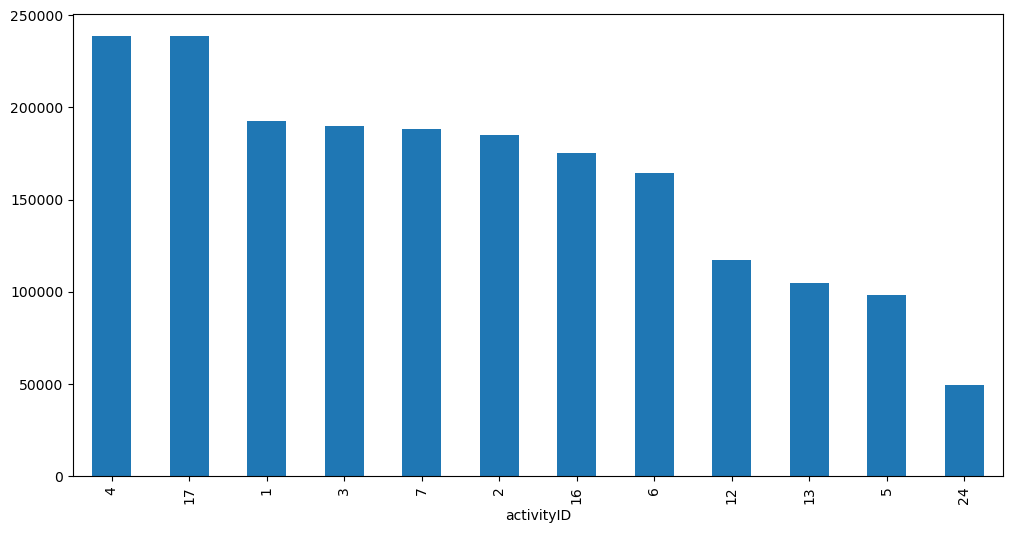

In [10]:
dataCol['activityID'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.show()

これより，全体の80% を超えるクラスはなさそうなので，そのまま利用する．教師データとテストデータに分割．

In [11]:
train_df = dataCol.sample(frac=0.8, random_state=1)
test_df = dataCol.drop(train_df.index)

データが用意できていそうなことを，確認する．教師データ，テストデータそれぞれを表示．分布が大きく変わっていなければよい．

In [12]:
pd.options.display.float_format = '{:.2f}'.format
train_df.describe()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
count,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,...,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00,1554298.00
mean,1705.05,8.08,107.48,32.75,-4.95,3.58,3.60,-4.89,3.57,3.79,...,9.37,-0.04,-2.18,0.01,-0.04,0.01,-31.58,1.39,17.25,4.57
std,1093.59,6.18,26.99,1.79,6.24,6.89,3.96,6.25,6.59,3.95,...,6.07,7.18,3.48,1.13,0.64,2.01,18.35,21.68,19.69,2.33
min,31.20,1.00,57.00,24.88,-145.37,-104.30,-101.45,-61.21,-61.84,-61.93,...,-61.14,-61.90,-62.31,-14.16,-13.04,-14.02,-172.62,-137.91,-102.72,1.00
25%,744.29,3.00,86.00,31.69,-8.97,1.06,1.16,-8.87,1.06,1.37,...,8.40,-2.07,-3.40,-0.21,-0.11,-0.44,-41.70,-12.47,3.80,2.00
50%,1480.09,6.00,104.00,33.12,-5.45,3.53,3.43,-5.38,3.57,3.66,...,9.55,-0.23,-1.99,0.00,-0.00,-0.00,-34.00,0.77,18.77,5.00
75%,2664.00,13.00,124.00,34.06,-0.96,6.45,6.53,-0.91,6.46,6.78,...,10.28,1.92,-0.60,0.13,0.12,0.09,-17.90,17.83,31.21,7.00
max,4245.68,24.00,202.00,35.50,62.86,155.70,157.76,52.82,62.26,61.92,...,61.97,62.05,60.94,17.42,13.59,14.48,91.55,93.70,146.90,9.00


In [13]:
test_df.describe()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
count,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,...,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00,388574.00
mean,1705.81,8.09,107.54,32.75,-4.95,3.60,3.60,-4.89,3.58,3.78,...,9.39,-0.05,-2.17,0.01,-0.04,0.01,-31.63,1.41,17.25,4.57
std,1092.95,6.17,27.00,1.79,6.24,6.92,3.95,6.25,6.61,3.93,...,6.07,7.22,3.47,1.13,0.64,2.02,18.34,21.70,19.76,2.33
min,31.29,1.00,57.00,24.88,-103.96,-80.98,-73.26,-60.97,-61.81,-61.58,...,-58.43,-61.91,-62.29,-24.00,-18.13,-11.74,-172.87,-136.93,-100.86,1.00
25%,745.46,3.00,86.00,31.62,-8.97,1.06,1.16,-8.86,1.07,1.36,...,8.43,-2.08,-3.40,-0.21,-0.11,-0.44,-41.78,-12.55,3.77,2.00
50%,1481.39,6.00,105.00,33.12,-5.45,3.53,3.43,-5.38,3.57,3.66,...,9.56,-0.22,-1.99,0.00,-0.00,-0.00,-34.04,0.81,18.76,5.00
75%,2662.13,13.00,124.00,34.06,-0.96,6.46,6.52,-0.90,6.46,6.77,...,10.31,1.92,-0.59,0.13,0.12,0.09,-18.01,17.88,31.23,7.00
max,4245.63,24.00,202.00,35.50,46.74,155.53,85.78,46.21,62.25,60.84,...,61.94,62.04,58.69,11.61,9.01,16.53,81.50,94.25,146.65,9.00


心拍数は，被験者の状態を追跡するための重要な要素なので，どれくらいの分布をしているかを箱ひげ図で可視化．そのまえに，箱ひげ図や後で出てくるヒートマップを描画するライブラリをインストール．

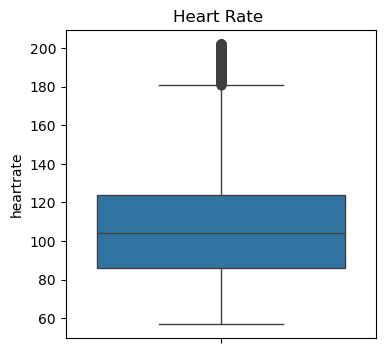

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4,4))
plt.title("Heart Rate ")
ax = sns.boxplot(y=train_df["heartrate"])

心拍数の箱ひげ図より，心拍数が180 を超える外れ値が存在していることがわかる．これらは非常に高い心拍数で，非常に激しいアクティビティや異常値である可能性がある．

最も負担の大きいアクティビティを見つけるために，各アクティビティごとの平均心拍数を示す棒グラフを描画．どのアクティビティが最も心拍数が高いか，つまり最も負担が大きいアクティビティを見つけることに利用できる．

<Axes: xlabel='activityID'>

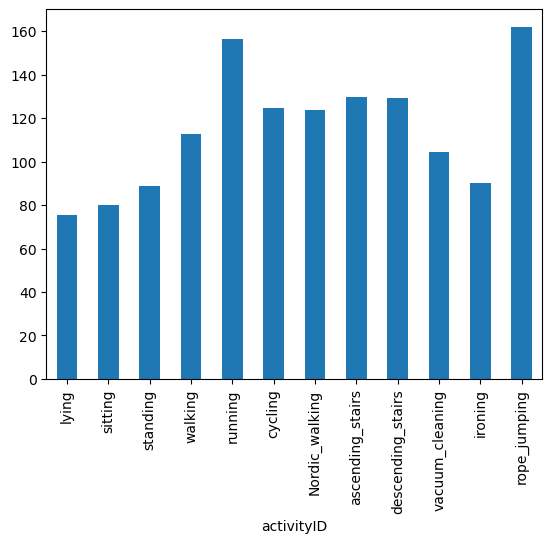

In [15]:
df_hr_act = train_df['heartrate'].groupby(train_df['activityID']).mean()
df_hr_act.index = df_hr_act.index.map(activityIDdict)
df_hr_act.plot(kind='bar')

この棒グラフからは，ランニングと縄跳びが心拍数への負荷が高そうなことが分かる．それらが他の活動に対して有意差があるかどうかは，後で確認する．

次にデータの異常や相関関係を調べるために，相関係数を求めてからヒートマップを作成する．

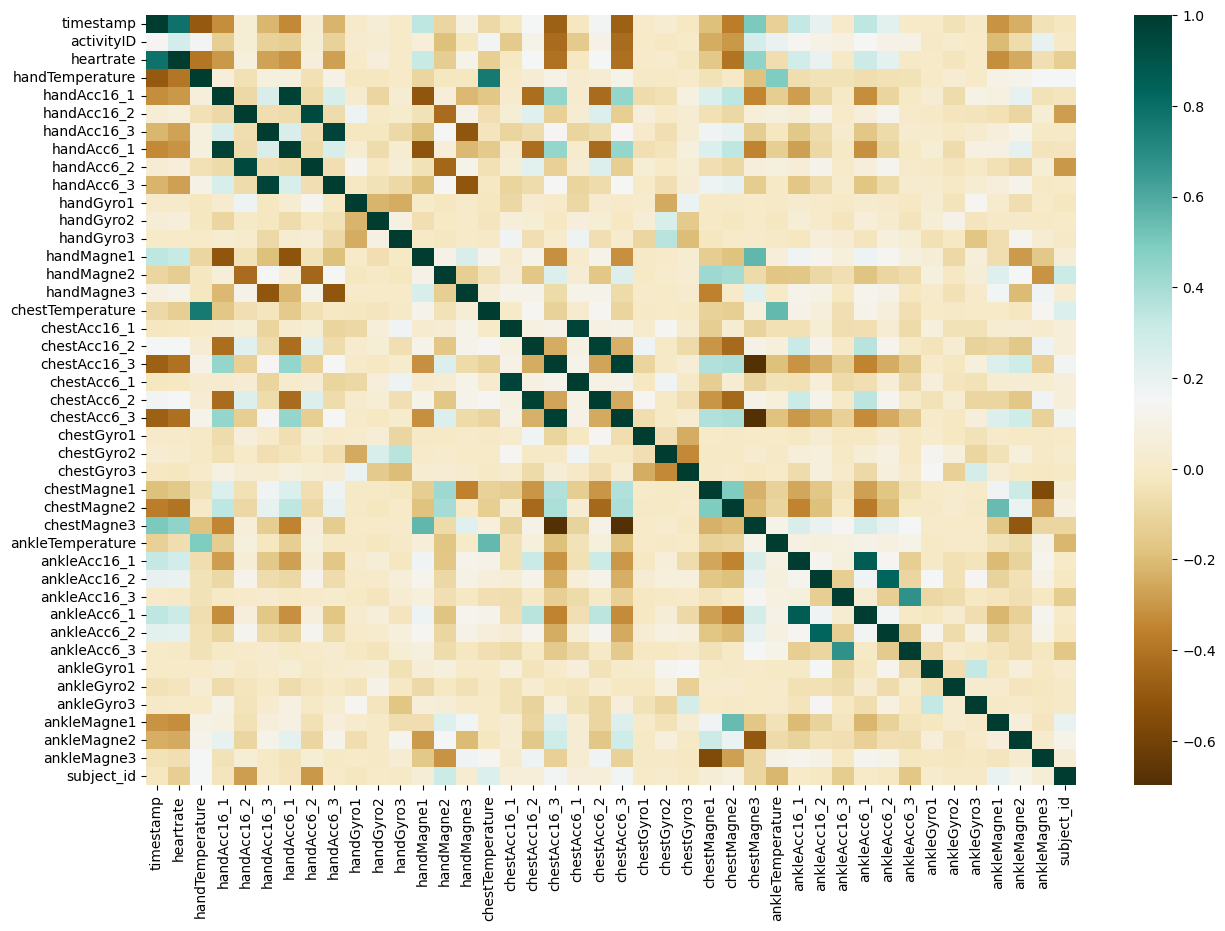

In [16]:
from pandas.plotting import scatter_matrix
df_corr = train_df.corr()
df_corr = df_corr.drop(['activityID'], axis = 1)

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=bool), cmap = "BrBG",ax=ax)
plt.show()

### 課題
##### 2023TS054 大橋七熙
> ヒートマップから⾔えそうなことを，考察してください．
### 考察
- timestampとheartrateの間に強い正の相関が見られる。
  - - これは、運動や計測が進行するにつれて、被験者の心拍数が上がり、体温が上昇していると考えられる。
- chest, hand, ancleの各センサーの加速度間にかなり強い正の相関が見られる。
  - - これは、これらのセンサーが同じ被験者の異なる部位に装着されているため、同じ動きを反映していると考えられる。ゆえにこれらセンサーのデータはどれか一つを用いれば十分である可能性が高い。
- chestMagne3とchestAcc6_3/16_3の間に強い負の相関が見られる。
  - - これは、胸部の磁気センサーと加速度センサーが互いに逆の動きを示していることを示している可能性がある。例えば、胸部が前後に動く際に、磁気センサーが特定の方向に変化し、加速度センサーが逆方向に変化することが考えられる。